# 01 - A/B Test Simulation
First I'll simulate two groups (A and B) with different probabilities of success, to model an A/B test.

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [106]:
n_users = 100
p_A = 0.3
p_B = 0.5

group_A = np.random.binomial(1, p_A, n_users)
group_B = np.random.binomial(1, p_B, n_users)

Plotting the results

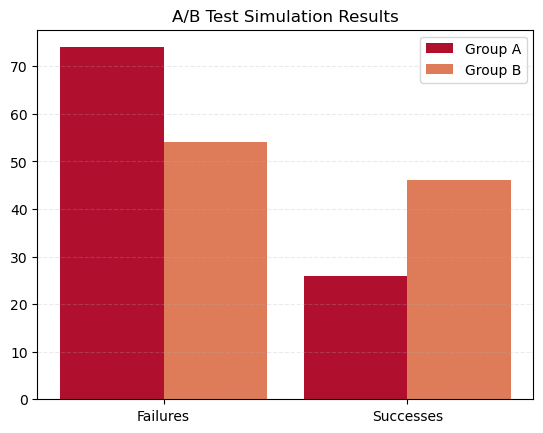

In [107]:
plt.hist([group_A, group_B], label=['Group A', 'Group B'], bins=[-0.5, 0.5, 1.5], rwidth=0.85, color=['#B10F2E', '#DE7C5A'])
plt.xticks([0,1], ['Failures', 'Successes'])
plt.title('A/B Test Simulation Results')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.25)
plt.tight_layout
plt.show()

Then I'll want to repeat this simulation multiple times. I think 10,000 is a good number, since it's the one I use when sampling in R. This is so I can understand the variability of outcomes.

In [108]:
n_trials = 10000
diffs = []

for _ in range(n_trials):
    A = np.random.binomial(1, p_A, n_users)
    B = np.random.binomial(1, p_B, n_users)
    diff = B.mean() - A.mean()
    diffs.append(diff)

Here `diffs` stores the difference in the success rate of A and B in each simulation, since I know that B has a higher probability, doing `B - A` is more likely to stay in the positive range. To see it better, I'll plot it 🤠

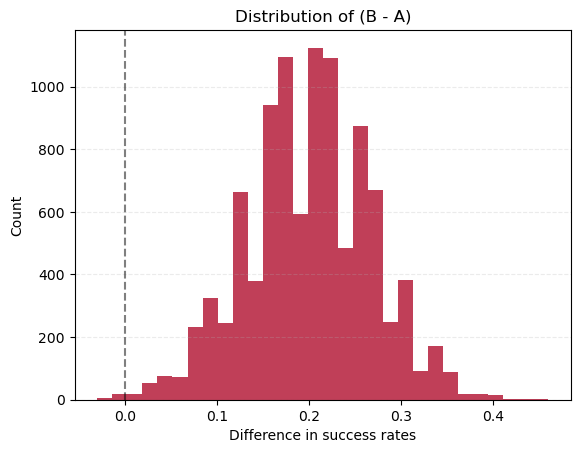

In [109]:
plt.hist(diffs, bins=30, color='#B10F2E', alpha=0.8)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.title('Distribution of (B - A)')
plt.xlabel('Difference in success rates')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.25)
plt.show()

So this plot shows us how many times there was a certain difference in success between A and B. Like there are very few instances where A outperformed B (the bars that are negative) which is normal considering A has a lower success probability. The highest bar is at a 0.2 difference (more than 1200 times of the 10,000) which is, again, very logical, considering the difference in success probability is `0.5 - 0.3 = 0.2`. This is a frequentist view, I would say.

Now I'll try to play with the standard error and confidence intervals. I know that $SE = \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$. A confidence interval of 95% means here $CI = \hat{p} \pm 1.96 \cdot SE$. The 1.96 value was found thanks to the [Z-score table](https://z-table.com)

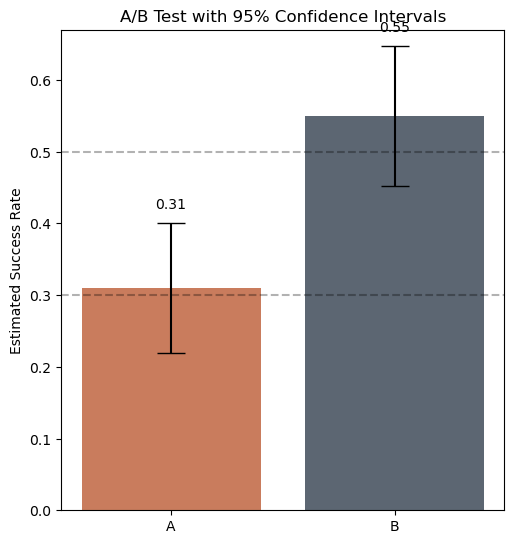

In [110]:
def compute_ci(p_hat, n, z=1.96):
    se = np.sqrt(p_hat * (1 - p_hat) / n)
    return p_hat - z * se, p_hat + z * se, se

mean_A = A.mean()
mean_B = B.mean()

ci_A_low, ci_A_high, se_A = compute_ci(mean_A, n)
ci_B_low, ci_B_high, se_B = compute_ci(mean_B, n)

means = [mean_A, mean_B]
errors = [1.96 * se_A, 1.96 * se_B]

plt.figure(figsize=(5.5,5.8))
plt.bar(['A', 'B'], means, yerr=errors, capsize=10, color=['#C97C5D', '#5C6672'])
plt.ylabel('Estimated Success Rate')
plt.title('A/B Test with 95% Confidence Intervals')
plt.ylim(0,0.67)

for i, (mean, err) in enumerate(zip(means, errors)):
    plt.text(i, mean + err + 0.02, f'{mean:.2f}', ha='center')

plt.axhline(0.3, color='black', linestyle='--', alpha=0.3)
plt.axhline(0.5, color='black', linestyle='--', alpha=0.3)


plt.tight_layout(pad=2)
plt.show()

At first, it seemed to me that the errors bars were somewhat large. But then I remembered this: even though I simulated this 10,000 times, I only have 100 users flipping a coin. To be sure of what I'm saying, I'm going to increase the users to 1000 and compare.

In [111]:
n_users_large = 1000

A_large = np.random.binomial(1, p_A, n_users_large)

mean_A_large = A_large.mean()

se_large = np.sqrt(mean_A_large * (1 - mean_A_large) / n_users_large)

err_large = 1.96 * se_large

# CI widths
width_100 = 2 * errors[0]
width_1000 = 2 * err_large

# Difference
diff = width_100 - width_1000
print(f'95% CI width (n=100): {width_100:.4f}')
print(f'95% CI width (n=1000): {width_1000:.4f}')
print(f'Difference in CI width: {diff:.4f}')

95% CI width (n=100): 0.1813
95% CI width (n=1000): 0.0579
Difference in CI width: 0.1234


The big difference confirms my earlier take. More users in one simulation does in fact reduce the error. Now to make sense of this A/B test, I'd have to see if the difference is significant. For this I'll follow step 1 of the A/B Testing and formulate the two hypothesis:
- **Null Hypothesis**: There is no difference between A and B.
- **Alternative hypothesis**: The success rates differ.  
And I'll run a two-sample z-test using my initial simulation with `n_users = 100`. The formula for the two-sample z-test is $z = \frac{\hat{p}_A - \hat{p}_B}{\sqrt{\hat{p}(1 - \hat{p})(\frac{1}{n_A}+\frac{1}{n_B})}}$ where $\hat{p}$ is the pooled proportion $\frac{x_A + x_B}{n_A + n_B}$.

In [112]:
x_A = A.sum()
x_B = B.sum()

p_pool = (x_A + x_B) / (n_users + n_users)

se_p_pool = np.sqrt(p_pool * (1 - p_pool) * (1/n_users + 1/n_users))

z = (mean_A - mean_B)/se_p_pool

p_value = 2 * (1 - norm.cdf(abs(z)))

print(f"z = {z:.4f}")
print(f"p-value = {p_value:.4f}")

z = -3.4279
p-value = 0.0006


If `p_value < 0.05`, the difference is statistically significant at 95% confidence, which is the case here. In other words, I can reject the null hypothesis at the 5% significance level. So we can conclude this notebook saying that the difference between A and B is significant and that the alternative hypothesis is true.